In [1]:
import os
from pathlib import Path
import mediapy
import torch
import numpy as np
import matplotlib.pyplot as plt

working_dir = Path.cwd()
while working_dir.name != 'gpudrive':
    working_dir = working_dir.parent
    if working_dir == Path.home():
        raise FileNotFoundError("Base directory 'gpudrive' not found")
os.chdir(working_dir)

from pygpudrive.env.dataset import SceneDataLoader
from pygpudrive.env.config import EnvConfig
from pygpudrive.env.env_torch import GPUDriveTorchEnv
from pygpudrive.visualize.utils import img_from_fig

import logging
logging.basicConfig(level=logging.INFO)

%load_ext autoreload
%autoreload 2

### Dataset

In [2]:
train_loader = SceneDataLoader(
    root="data/processed/training",
    batch_size=2, # Number of worlds
    dataset_size=1000,
    sample_with_replacement=False,
    shuffle=False,
)

### Model

- Training run: [here](https://wandb.ai/emerge_/paper_1_self_play/runs/PPO__S_3__01_09_20_23_08_617?nw=nwuserdaphnecor)
- GR: 98.5%
- Trained on scenes: 

```
{'data/processed/training/tfrecord-00000-of-01000_103.json', 
'data/processed/training/tfrecord-00000-of-01000_100.json', 
'data/processed/training/tfrecord-00000-of-01000_1.json'}
```

In [6]:
from examples.experiments.eval.evaluate import load_policy, rollout

policy = load_policy(
    path_to_cpt='examples/experiments/eval/models',
    model_name='model_PPO_S_2__01_17_11_25_25_116_003615',
    device='cpu'
)

INFO:root:Load model from examples/experiments/eval/models/model_PPO_S_2__01_17_11_25_25_116_003615.pt
INFO:root:Load model parameters


In [7]:
# Check that the model weights are not random
# for name, param in policy.state_dict().items():
#     print(f"{name} - Mean: {param.mean():.4f}, Std: {param.std():.4f}")

In [8]:
policy


LateFusionTransformer(
  (act_func): ReLU()
  (ego_embed): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (partner_embed): Sequential(
    (0): Linear(in_features=6, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (road_map_embed): Sequential(
    (0): Linear(in_features=13, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
  )
  (actor): Linear(in_features=192, out_features=651, bias=True)
  (critic): Linear(in_features=192, out_features=1, bias=True)
)

### GPUDriveTorchEnv

['data/processed/training/tfrecord-00000-of-01000_1.json', 'data/processed/training/tfrecord-00000-of-01000_100.json']
observation_space: Box(0.0, 255.0, (13, 3048), float32)
obs shape: torch.Size([13, 3048])
obs dtype: torch.float32 

action_space: Discrete(651)


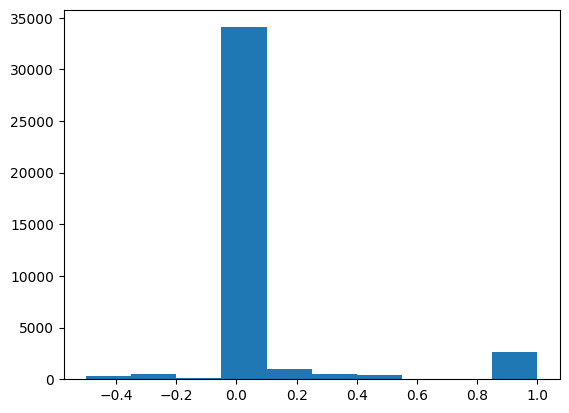

In [9]:
env = GPUDriveTorchEnv(
    config=EnvConfig(),
    data_loader=train_loader,
    max_cont_agents=128, 
    device="cpu",
)

print(env.data_batch)

obs = env.reset(env.cont_agent_mask)

print(f'observation_space: {env.observation_space}')
print(f'obs shape: {obs.shape}')
print(f'obs dtype: {obs.dtype} \n')

print(f'action_space: {env.action_space}')

plt.hist(obs.flatten());

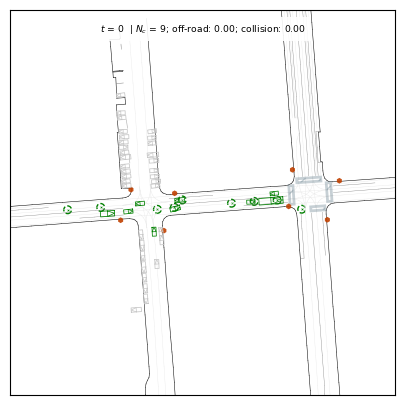

In [11]:
# Show simulator to make sure we're at the same state
env.vis.figsize = (5, 5)
sim_states = env.vis.plot_simulator_state(
    env_indices=[0],
    zoom_radius=100,
    time_steps=[0],
)

sim_states[0]

In [19]:
goal_achieved, collided, off_road, controlled, not_goal_nor_crashed, frames = rollout(
    env=env, 
    policy=policy, 
    device='cpu', 
    deterministic=False,
    render_sim_state=True,
    zoom_radius=100,
)

print(f'\n Results: \n')
print(f'Goal achieved: {goal_achieved}')
print(f'Collided: {collided}')
print(f'Off road: {off_road}')
print(f'Not goal nor crashed: {not_goal_nor_crashed}')
print(f'Controlled: {controlled}')

INFO:root:Rendering time step 0


INFO:root:Rendering time step 5
INFO:root:Rendering time step 10
INFO:root:Rendering time step 15
INFO:root:Rendering time step 20
INFO:root:Rendering time step 25
INFO:root:Rendering time step 30
INFO:root:Rendering time step 35
INFO:root:Rendering time step 40
INFO:root:Rendering time step 45
INFO:root:Rendering time step 50
INFO:root:Rendering time step 55
INFO:root:Rendering time step 60
INFO:root:Rendering time step 65
INFO:root:Rendering time step 70
INFO:root:Rendering time step 75
INFO:root:Rendering time step 80
INFO:root:Rendering time step 85
INFO:root:Rendering time step 90



 Results: 

Goal achieved: tensor([0.8889, 1.0000])
Collided: tensor([0., 0.])
Off road: tensor([0., 0.])
Not goal nor crashed: tensor([0.1111, 0.0000])
Controlled: tensor([9., 4.])


0,1

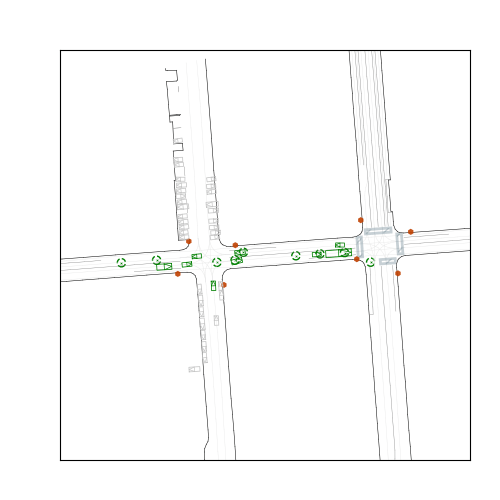
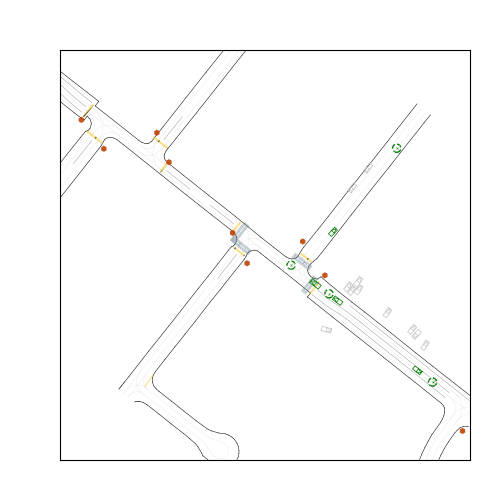

In [20]:
# Show rollout videos
mediapy.show_videos(frames, fps=2, codec='gif', columns=2)

In [13]:
for i in range(5):

    mediapy.write_video(
        f"odd_scene_{i}.gif", np.array(frames[i]), fps=10, codec="gif"
    )

### Sanity check | Bugs in the scene?

- Why are the agents on the RHS not even approaching their goals?
- Debug check: Step the agents using the log replay trajectories in the 3rd scene

In [14]:
env_idx = 4

In [15]:
# sim_state = env.vis.plot_simulator_state(
#     env_indices=[env_idx],
#     plot_log_replay_trajectory=True,
#     zoom_radius=310
# )[0]

# # Its a long scene
# sim_state

In [16]:
# # Rollout with expert actions
# delta_env = GPUDriveTorchEnv(
#     config=EnvConfig(dynamics_model="delta_local"),
#     data_loader=train_loader,
#     max_cont_agents=128,  # Number of agents to control
#     device="cpu",
# )

# obs = delta_env.reset()
# sim_frames = []
# agent_obs_frames = []

# expert_actions, _, _, _ = delta_env.get_expert_actions()

# for t in range(80):
#     print(f"Step: {t}")

#     # Step the environment
#     delta_env.step_dynamics(expert_actions[:, :, t, :])

#     highlight_agent = torch.where(delta_env.cont_agent_mask[env_idx, :])[0][-2].item()

#     # Make video of both views
#     sim_states = delta_env.vis.plot_simulator_state(
#         env_indices=[env_idx],
#         zoom_radius=130,
#         time_steps=[t],
#         #center_agent_indices=[highlight_agent],
#     )

#     agent_obs = delta_env.vis.plot_agent_observation(
#         env_idx=env_idx,
#         agent_idx=highlight_agent,
#         figsize=(10, 10),
#     )

#     sim_frames.append(img_from_fig(sim_states[0]))
#     agent_obs_frames.append(img_from_fig(agent_obs))

#     next_obs = delta_env.get_obs()
#     done = delta_env.get_dones()

#     if done.all().bool():
#         break

In [5]:
mediapy.write_video(
    "sim_video.gif", np.array(sim_frames), fps=10, codec="gif"
)

mediapy.write_video(
    "obs_video.gif", np.array(agent_obs_frames), fps=10, codec="gif"
)

### PufferEnv


In [ ]:
from integrations.rl.puffer.puffer_env import PufferGPUDrive

puffer_env = PufferGPUDrive(
    data_loader=train_loader,
    device="cpu",
    config=EnvConfig(),
    train_config=None,
)

puffer_env.reset()

puffer_obs = puffer_env.observations

puffer_env.controlled_agent_mask.sum()

In [14]:
print(f'observation_space: {puffer_env.observation_space}')
print(f'obs shape: {puffer_obs.shape}')
print(f'obs dtype: {puffer_obs.dtype} \n')

print(f'action_space: {puffer_env.action_space}')

observation_space: Box(0.0, 255.0, (9, 3368), float32)
obs shape: (9, 3368)
obs dtype: float32 

action_space: MultiDiscrete([672 672 672 672 672 672 672 672 672])


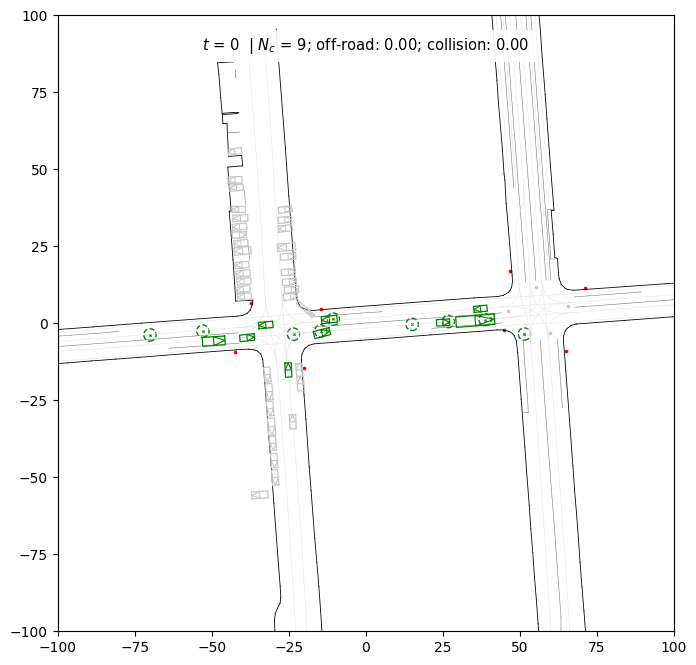

In [15]:
puffer_env.env.vis.figsize = (8, 8)
puffer_sim_state = puffer_env.env.vis.plot_simulator_state(
    env_indices=[0],
    zoom_radius=100,
    time_steps=[0],
)

puffer_sim_state[0]

In [18]:
puffer_env.env.get_obs()

tensor([[[0.0000, 0.1533, 0.2089,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.1507, 0.2097,  ..., 0.0000, 0.0000, 1.0000],
         [0.0111, 0.1538, 0.2055,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]]])

puffer_obs min: 0.0
puffer_obs max: 0.0


(array([  1075.,   1667.,    462., 395777.,   3955.,   1091.,   1369.,
             0.,      0.,  25708.]),
 array([-0.49998656, -0.34998789, -0.19998924, -0.04999059,  0.10000806,
         0.25000674,  0.40000537,  0.55000401,  0.70000267,  0.85000134,
         1.        ]),
 <BarContainer object of 10 artists>)

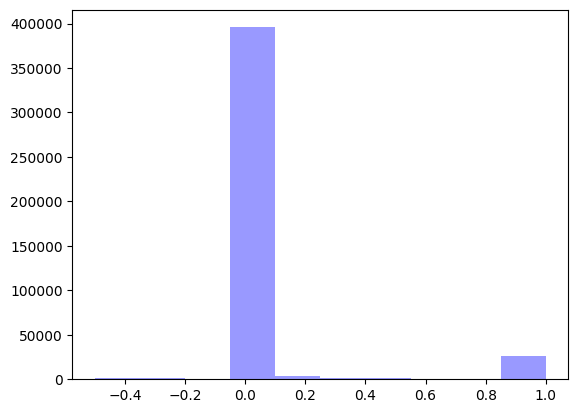

In [24]:
# print min max
print(f'puffer_obs min: {puffer_obs.min()}')
print(f'puffer_obs max: {puffer_obs.max()}')

plt.hist(puffer_env.env.get_obs().flatten(), color='b', alpha=0.4)

(array([  1075.,   1667.,    462., 395777.,   3955.,   1091.,   1369.,
             0.,      0.,  25708.]),
 array([-0.49998656, -0.34998789, -0.19998924, -0.04999059,  0.10000806,
         0.25000674,  0.40000537,  0.55000401,  0.70000267,  0.85000134,
         1.        ]),
 <BarContainer object of 10 artists>)

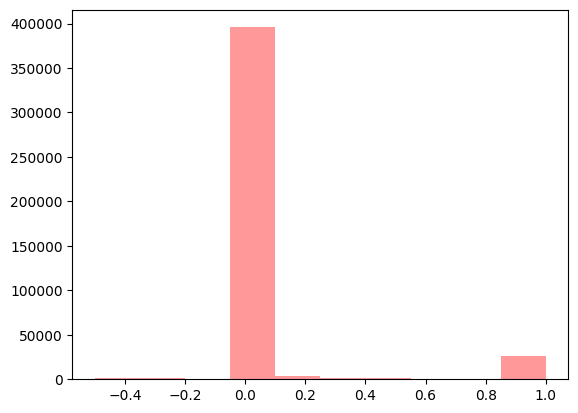

In [25]:
plt.hist(env.get_obs().flatten(), color='r', alpha=0.4)

In [17]:
puffer_obs

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)